In [11]:
DATASET_DIR = ''
SAVE_DIR = './'

import os
import pandas as pd
import keras
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from keras import backend as K

environment='L'


In [61]:

if environment == 'S':
    os.environ["CUDA_VISIBLE_DEVICES"] = '1'  
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.allow_growth =\
        True
    sess = tf.Session(config=config)
    keras.backend.set_session(sess)
elif environment == 'L':
    os.chdir("/Users/omerorhan/Desktop/lexinsight/AutomaticTextUnderstanding/venv/Source")

In [78]:

'''
X = pd.read_csv(os.path.join(DATASET_DIR, 'essay_set1_merged.csv'), encoding='ISO-8859-1')
#X = (X[(X["essay_set"] == 1) | (X["essay_set"] == 2)])
X = (X[(X["essay_set"] == 1)])
print(X.columns)
#y = X[[ 'domain1_score', 'Content',
#       'Organization', 'Word Choice', 'Sentence Fluency', 'Conventions']]
y_domain_score=X[['rater1_domain1']]
y_content=X[['Content']]
y_organization=X[['Organization']]
y_wordChoice=X[['Word Choice']]
y_sentenceFluency=X[['Sentence Fluency']]
y_conventions=X[['Conventions']]
  
#X = (X[(X["essay_set"] == 1) | (X["essay_set"] == 2)])

X = X.dropna(axis=1)
os.chdir("/Users/omerorhan/Desktop/lexinsight/AutomaticTextUnderstanding/venv/Source")
'''

'\nX = pd.read_csv(os.path.join(DATASET_DIR, \'essay_set1_merged.csv\'), encoding=\'ISO-8859-1\')\n#X = (X[(X["essay_set"] == 1) | (X["essay_set"] == 2)])\nX = (X[(X["essay_set"] == 1)])\nprint(X.columns)\n#y = X[[ \'domain1_score\', \'Content\',\n#       \'Organization\', \'Word Choice\', \'Sentence Fluency\', \'Conventions\']]\ny_domain_score=X[[\'rater1_domain1\']]\ny_content=X[[\'Content\']]\ny_organization=X[[\'Organization\']]\ny_wordChoice=X[[\'Word Choice\']]\ny_sentenceFluency=X[[\'Sentence Fluency\']]\ny_conventions=X[[\'Conventions\']]\n  \n#X = (X[(X["essay_set"] == 1) | (X["essay_set"] == 2)])\n\nX = X.dropna(axis=1)\nos.chdir("/Users/omerorhan/Desktop/lexinsight/AutomaticTextUnderstanding/venv/Source")\n'

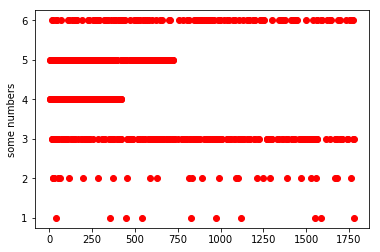

rater1_domain1
1.0     10
2.0     28
3.0    196
4.0    922
5.0    507
6.0    120
dtype: int64
Index(['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',
       'rater3_domain1', 'domain1_score', 'domain1_score_copy',
       'rater1_domain2', 'rater2_domain2', 'domain2_score', 'rater1_trait1',
       'rater1_trait2', 'rater1_trait3', 'rater1_trait4', 'rater1_trait5',
       'rater1_trait6', 'rater2_trait1', 'rater2_trait2', 'rater2_trait3',
       'rater2_trait4', 'rater2_trait5', 'rater2_trait6', 'rater3_trait1',
       'rater3_trait2', 'rater3_trait3', 'rater3_trait4', 'rater3_trait5',
       'rater3_trait6'],
      dtype='object')
rater1_domain1
1.0     10
2.0     28
3.0    196
4.0    922
5.0    507
6.0    120
dtype: int64


In [146]:
X = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.csv'),  encoding='ISO-8859-1')
#X = (X[(X["essay_set"] == 1) | (X["essay_set"] == 2)])
X = (X[(X["essay_set"] == 1)])
#y = X['rater1_domain1']
#X = X.dropna(axis=1)
#X = X.drop(columns=['rater1_domain1', 'rater2_domain1'])
#X[(X["essay_set"] == 1) | (X["essay_set"] == 2)]

#print("x shape"+ str(X.shape))
#print("y shape"+ str(y))

import matplotlib.pyplot as plt
plt.plot(y, 'ro')
plt.ylabel('some numbers')
plt.show()

#y = y.to_frame()
#print(y.columns)
#print(type(y))

#X =X.to_frame()
#print((y.groupby("rater1_domain1").size()))
print((X.groupby("rater1_domain1").size()))

print(X.columns)
X_1 =  X[(X['rater1_domain1']==1) |( X['rater1_domain1']==2)|( X['rater1_domain1']==3)
         |( X['rater1_domain1']==6) ]

X_4 = X[(X['rater1_domain1']==4)]#[1:200]
X_5 = X[(X['rater1_domain1']==5)]#[1:200]

X = pd.concat([X_1,X_4,X_5])
print((X.groupby("rater1_domain1").size()))

y = X['rater1_domain1']

X.to_csv("/Users/omerorhan/Desktop/lexinsight/AutomaticTextUnderstanding/venv/Source/xxx.csv",index=False)

Preprocessing the Data
We will preprocess all essays and convert them to feature vectors so that they can be fed into the RNN.

These are all helper functions used to clean the essays.

In [147]:
minimum_scores = [-1, 2, 1, 0, 0, 0, 0, 0, 0]
maximum_scores = [-1, 12, 6, 3, 3, 4, 4, 30, 60]

import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec

def essay_to_wordlist(essay_v, remove_stopwords):
    """Remove the tagged labels and word tokenize the sentence."""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

def makeFeatureVec(words, model, num_features):
    """Make Feature Vector from the words list of an Essay."""
    featureVec = np.zeros((num_features,),dtype="float32")
    num_words = 0.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set:
            num_words += 1
            featureVec = np.add(featureVec,model[word])        
    featureVec = np.divide(featureVec,num_words)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs


Defining the model
Here we define a 2-Layer LSTM Model.

Note that instead of using sigmoid activation in the output layer we will use Relu since we are not normalising training labels.



In [158]:

from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K
from keras.utils.np_utils import to_categorical
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD,Adam
opt = SGD(lr=0.01)
def get_model():
    """Define the model.""" 
    inputs = Input(shape=(1, 300))
    extract = LSTM(300,  return_sequences=True)(inputs)
    class11 = LSTM(64, recurrent_dropout=0.4)(extract)
    output1 = Dense(7, activation='sigmoid')(class11)
    '''
    output2 = Dense(7, activation='sigmoid')(class11)
    output3 = Dense(7, activation='sigmoid')(class11)
    output4 = Dense(7, activation='sigmoid')(class11)
    output5 = Dense(7, activation='sigmoid')(class11)
    output6 = Dense(7, activation='sigmoid')(class11)
    '''
    model = Model(inputs=inputs,outputs=[output1])
    opt = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    #model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    print(model.summary())
    return model


Training Phase
Now we train the model on the dataset.

We will use 5-Fold Cross Validation and measure the Quadratic Weighted Kappa for each fold. We will then calculate Average Kappa for all the folds.

In [159]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score

'''
y_domain_score=X[['rater1_domain1']]
y_content=X[['Content']]
y_organization=X[['Organization']]
y_wordChoice=X[['Word Choice']]
y_sentenceFluency=X[['Sentence Fluency']]
y_conventions=X[['Conventions']]
'''

K.clear_session()

results = []
y_pred_list = []

count = 1
print(X.shape)
train_essays = X['essay']
print(train_essays[1:10])
sentences = []
for essay in train_essays:
        sentences += essay_to_sentences(essay, remove_stopwords = True)
        
# Initializing variables for word2vec model.
num_features = 300 
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3

print("Training Word2Vec Model...")
model = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,
                 window = context, sample = downsampling)

model.init_sims(replace=True)
model.wv.save_word2vec_format('word2vecmodel.bin', binary=True)

clean_train_essays = []

# Generate training and testing data word vectors.
for essay_v in train_essays:
    clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)

trainDataVecs = np.array(trainDataVecs)
print("trainDataVecs"+str(trainDataVecs.shape))

trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
validsiz=200
'''
y_domain_score_c = to_categorical(y)

y_content_c = to_categorical(y_content)
y_organization_c = to_categorical(y_organization)
y_wordChoice_c = to_categorical(y_wordChoice)
y_sentenceFluency_c = to_categorical(y_sentenceFluency)
y_conventions_c = to_categorical(y_conventions)

print(y_domain_score_c)
'''
print(y[1:10])
y_c = to_categorical(y)
lstm_model = get_model()
'''
history = lstm_model.fit(trainDataVecs,
                         y=[y_domain_score_c,y_content_c,y_organization_c,y_wordChoice_c
                             ,y_sentenceFluency_c,y_conventions_c] ,validation_split=0.2
                         ,batch_size=64, epochs=50)
'''

history = lstm_model.fit(trainDataVecs,
                         y_c ,validation_split=0.2
                         ,batch_size=64, epochs=50)

print(history.history.keys())
if count == 1:
     lstm_model.save('final_lstm.h5')

'''
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.subplot(222)
valacc = history.history['val_dense_1_acc']
acc = history.history['dense_1_acc']
plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
plt.plot(epochs, acc, 'y', label='categorical_accuracy')
plt.title('Val Cat. and Cat. Accuracy for domain score')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
'''
'''
plt.subplot(223)
valacc = history.history['val_dense_2_acc']
acc = history.history['dense_2_acc']
plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
plt.plot(epochs, acc, 'y', label='categorical_accuracy')
plt.title('Val Cat. and Cat. Accuracy for Content')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.subplot(224)
valacc = history.history['val_dense_3_acc']
acc = history.history['dense_3_acc']
plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
plt.plot(epochs, acc, 'y', label='categorical_accuracy')
plt.title('Val Cat. and Cat. Accuracy for Organization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.subplot(234)
valacc = history.history['val_dense_4_acc']
acc = history.history['dense_4_acc']
plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
plt.plot(epochs, acc, 'y', label='categorical_accuracy')
plt.title('Val Cat. and Cat. Accuracy for Word Choice')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.subplot(244)
valacc = history.history['val_dense_5_acc']
acc = history.history['dense_5_acc']
plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
plt.plot(epochs, acc, 'y', label='categorical_accuracy')
plt.title('Val Cat. and Cat. Accuracy for Sentence Fluency')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.subplot(344)
valacc = history.history['val_dense_6_acc']
acc = history.history['dense_6_acc']
plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
plt.plot(epochs, acc, 'y', label='categorical_accuracy')
plt.title('Val Cat. and Cat. Accuracy for Conventions')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#break
count += 1

'''

(1783, 29)
14    Dear, In this world today we should have every...
15    Dear @ORGANIZATION1, The computer blinked to l...
18    I aegre waf the evansmant ov tnachnolage. The ...
19    Well computers can be a good or a bad thing. I...
21    Dear local Newspaper @CAPS1 a take all your co...
23    Dear local newspaper, I've heard that not many...
26    Computers a good because you can get infermati...
32    Dear, @ORGANIZATION1 I think the effects that ...
36    Dear @ORGANIZATION1, @CAPS1 has been brought t...
Name: essay, dtype: object


Training Word2Vec Model...


/anaconda3/envs/tf-cpu/lib/python3.5/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


trainDataVecs(1783, 300)
14    3.0
15    6.0
18    2.0
19    3.0
21    2.0
23    6.0
26    2.0
32    3.0
36    6.0
Name: rater1_domain1, dtype: float64


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 300)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 455       
Total params: 815,095
Trainable params: 815,095
Non-trainable params: 0
_________________________________________________________________
None


Train on 1426 samples, validate on 357 samples
Epoch 1/50


  64/1426 [>.............................] - ETA: 35s - loss: 0.6933 - acc: 0.4040

 192/1426 [===>..........................] - ETA: 11s - loss: 0.6911 - acc: 0.6778

 320/1426 [=====>........................] - ETA: 6s - loss: 0.6888 - acc: 0.7545 

 448/1426 [========>.....................] - ETA: 4s - loss: 0.6863 - acc: 0.7966

 576/1426 [===========>..................] - ETA: 2s - loss: 0.6834 - acc: 0.8155

 704/1426 [=============>................] - ETA: 2s - loss: 0.6798 - acc: 0.8295

 832/1426 [================>.............] - ETA: 1s - loss: 0.6759 - acc: 0.8383

 960/1426 [===================>..........] - ETA: 1s - loss: 0.6712 - acc: 0.8482

1088/1426 [=====================>........] - ETA: 0s - loss: 0.6657 - acc: 0.8553

1216/1426 [========================>.....] - ETA: 0s - loss: 0.6595 - acc: 0.8593

1344/1426 [===========================>..] - ETA: 0s - loss: 0.6524 - acc: 0.8629

1426/1426 [==============================] - 3s 2ms/step - loss: 0.6470 - acc: 0.8656 - val_loss: 0.5777 - val_acc: 0.7143


Epoch 2/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.5395 - acc: 0.8884

 192/1426 [===>..........................] - ETA: 0s - loss: 0.5219 - acc: 0.8958

 320/1426 [=====>........................] - ETA: 0s - loss: 0.5039 - acc: 0.9018

 448/1426 [========>.....................] - ETA: 0s - loss: 0.4879 - acc: 0.8999

 576/1426 [===========>..................] - ETA: 0s - loss: 0.4686 - acc: 0.9053

 704/1426 [=============>................] - ETA: 0s - loss: 0.4539 - acc: 0.9026

 832/1426 [================>.............] - ETA: 0s - loss: 0.4406 - acc: 0.9001

 960/1426 [===================>..........] - ETA: 0s - loss: 0.4267 - acc: 0.9000

1088/1426 [=====================>........] - ETA: 0s - loss: 0.4110 - acc: 0.9018

1216/1426 [========================>.....] - ETA: 0s - loss: 0.3999 - acc: 0.9001

1344/1426 [===========================>..] - ETA: 0s - loss: 0.3909 - acc: 0.8988

1426/1426 [==============================] - 1s 502us/step - loss: 0.3843 - acc: 0.8990 - val_loss: 0.5398 - val_acc: 0.7143


Epoch 3/50


  64/1426 [>.............................] - ETA: 1s - loss: 0.2917 - acc: 0.8929

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2932 - acc: 0.8839

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2764 - acc: 0.8946

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2792 - acc: 0.8922

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2760 - acc: 0.8934

 704/1426 [=============>................] - ETA: 0s - loss: 0.2696 - acc: 0.8969

 832/1426 [================>.............] - ETA: 0s - loss: 0.2668 - acc: 0.8987

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2682 - acc: 0.8973

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2697 - acc: 0.8963

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2716 - acc: 0.8952

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2667 - acc: 0.8984

1426/1426 [==============================] - 1s 505us/step - loss: 0.2657 - acc: 0.8990 - val_loss: 0.5112 - val_acc: 0.7143


Epoch 4/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2759 - acc: 0.8839

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2667 - acc: 0.8943

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2597 - acc: 0.9009

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2602 - acc: 0.9011

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2494 - acc: 0.9077

 704/1426 [=============>................] - ETA: 0s - loss: 0.2501 - acc: 0.9083

 832/1426 [================>.............] - ETA: 0s - loss: 0.2542 - acc: 0.9049

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2573 - acc: 0.9021

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2591 - acc: 0.9007

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2625 - acc: 0.8985

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2608 - acc: 0.8997

1426/1426 [==============================] - 1s 510us/step - loss: 0.2610 - acc: 0.8990 - val_loss: 0.4989 - val_acc: 0.7143


Epoch 5/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2972 - acc: 0.8661

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2973 - acc: 0.8676

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2817 - acc: 0.8795

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2724 - acc: 0.8890

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2667 - acc: 0.8943

 704/1426 [=============>................] - ETA: 0s - loss: 0.2648 - acc: 0.8957

 832/1426 [================>.............] - ETA: 0s - loss: 0.2618 - acc: 0.8987

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2620 - acc: 0.8982

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2598 - acc: 0.8992

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2607 - acc: 0.8985

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2600 - acc: 0.8992

1426/1426 [==============================] - 1s 503us/step - loss: 0.2613 - acc: 0.8990 - val_loss: 0.5260 - val_acc: 0.7143


Epoch 6/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.3104 - acc: 0.8661

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2625 - acc: 0.8988

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2582 - acc: 0.9009

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2636 - acc: 0.8967

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2626 - acc: 0.8968

 704/1426 [=============>................] - ETA: 0s - loss: 0.2526 - acc: 0.9030

 832/1426 [================>.............] - ETA: 0s - loss: 0.2614 - acc: 0.8977

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2603 - acc: 0.8985

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2575 - acc: 0.9002

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2580 - acc: 0.9004

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2594 - acc: 0.8990

1426/1426 [==============================] - 1s 501us/step - loss: 0.2599 - acc: 0.8990 - val_loss: 0.5064 - val_acc: 0.7143


Epoch 7/50


  64/1426 [>.............................] - ETA: 1s - loss: 0.2846 - acc: 0.8839

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2566 - acc: 0.9003

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2512 - acc: 0.9027

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2623 - acc: 0.8960

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2582 - acc: 0.8993

 704/1426 [=============>................] - ETA: 0s - loss: 0.2592 - acc: 0.8989

 832/1426 [================>.............] - ETA: 0s - loss: 0.2618 - acc: 0.8977

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2558 - acc: 0.9018

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2575 - acc: 0.9007

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2596 - acc: 0.8992

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2588 - acc: 0.8994

1426/1426 [==============================] - 1s 512us/step - loss: 0.2598 - acc: 0.8990 - val_loss: 0.5094 - val_acc: 0.7143


Epoch 8/50


  64/1426 [>.............................] - ETA: 1s - loss: 0.2462 - acc: 0.9062

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2696 - acc: 0.8899

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2759 - acc: 0.8866

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2671 - acc: 0.8935

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2650 - acc: 0.8953

 704/1426 [=============>................] - ETA: 0s - loss: 0.2628 - acc: 0.8961

 832/1426 [================>.............] - ETA: 0s - loss: 0.2623 - acc: 0.8959

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2570 - acc: 0.8994

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2589 - acc: 0.8989

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2574 - acc: 0.9006

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2587 - acc: 0.8990

1426/1426 [==============================] - 1s 514us/step - loss: 0.2595 - acc: 0.8990 - val_loss: 0.5187 - val_acc: 0.7143


Epoch 9/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2407 - acc: 0.9063

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2568 - acc: 0.8988

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2744 - acc: 0.8884

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2750 - acc: 0.8871

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2745 - acc: 0.8879

 704/1426 [=============>................] - ETA: 0s - loss: 0.2723 - acc: 0.8888

 832/1426 [================>.............] - ETA: 0s - loss: 0.2682 - acc: 0.8918

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2646 - acc: 0.8952

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2626 - acc: 0.8968

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2610 - acc: 0.8983

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2601 - acc: 0.8988

1426/1426 [==============================] - 1s 506us/step - loss: 0.2600 - acc: 0.8990 - val_loss: 0.5236 - val_acc: 0.7143


Epoch 10/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2876 - acc: 0.8839

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2698 - acc: 0.8929

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2583 - acc: 0.8991

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2510 - acc: 0.9037

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2565 - acc: 0.9003

 704/1426 [=============>................] - ETA: 0s - loss: 0.2667 - acc: 0.8945

 832/1426 [================>.............] - ETA: 0s - loss: 0.2652 - acc: 0.8953

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2619 - acc: 0.8976

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2576 - acc: 0.9007

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2558 - acc: 0.9018

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2589 - acc: 0.8997

1426/1426 [==============================] - 1s 564us/step - loss: 0.2594 - acc: 0.8990 - val_loss: 0.5080 - val_acc: 0.7143


Epoch 11/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2773 - acc: 0.8839

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2691 - acc: 0.8899

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2669 - acc: 0.8929

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2684 - acc: 0.8922

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2615 - acc: 0.8973

 704/1426 [=============>................] - ETA: 0s - loss: 0.2608 - acc: 0.8977

 832/1426 [================>.............] - ETA: 0s - loss: 0.2642 - acc: 0.8959

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2599 - acc: 0.8985

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2605 - acc: 0.8976

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2616 - acc: 0.8966

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2589 - acc: 0.8984

1426/1426 [==============================] - 1s 575us/step - loss: 0.2589 - acc: 0.8990 - val_loss: 0.5109 - val_acc: 0.7143


Epoch 12/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2399 - acc: 0.9062

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2258 - acc: 0.9182

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2367 - acc: 0.9107

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2440 - acc: 0.9082

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2538 - acc: 0.9028

 704/1426 [=============>................] - ETA: 0s - loss: 0.2613 - acc: 0.8977

 832/1426 [================>.............] - ETA: 0s - loss: 0.2614 - acc: 0.8980

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2591 - acc: 0.8997

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2556 - acc: 0.9018

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2548 - acc: 0.9023

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2588 - acc: 0.8997

1426/1426 [==============================] - 1s 548us/step - loss: 0.2591 - acc: 0.8990 - val_loss: 0.5025 - val_acc: 0.7143


Epoch 13/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2722 - acc: 0.8884

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2718 - acc: 0.8914

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2608 - acc: 0.8982

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2648 - acc: 0.8948

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2604 - acc: 0.8988

 704/1426 [=============>................] - ETA: 0s - loss: 0.2573 - acc: 0.9006

 832/1426 [================>.............] - ETA: 0s - loss: 0.2588 - acc: 0.8990

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2568 - acc: 0.9003

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2625 - acc: 0.8968

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2606 - acc: 0.8978

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2599 - acc: 0.8982

1426/1426 [==============================] - 1s 522us/step - loss: 0.2586 - acc: 0.8990 - val_loss: 0.5142 - val_acc: 0.7143


Epoch 14/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2382 - acc: 0.9107

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2442 - acc: 0.9077

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2549 - acc: 0.9000

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2533 - acc: 0.9011

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2556 - acc: 0.9003

 704/1426 [=============>................] - ETA: 0s - loss: 0.2572 - acc: 0.8981

 832/1426 [================>.............] - ETA: 0s - loss: 0.2599 - acc: 0.8973

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2600 - acc: 0.8970

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2591 - acc: 0.8978

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2614 - acc: 0.8966

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2591 - acc: 0.8980

1426/1426 [==============================] - 1s 518us/step - loss: 0.2586 - acc: 0.8990 - val_loss: 0.4859 - val_acc: 0.7143


Epoch 15/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2302 - acc: 0.9196

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2757 - acc: 0.8929

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2723 - acc: 0.8902

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2724 - acc: 0.8897

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2709 - acc: 0.8919

 704/1426 [=============>................] - ETA: 0s - loss: 0.2641 - acc: 0.8961

 832/1426 [================>.............] - ETA: 0s - loss: 0.2612 - acc: 0.8977

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2592 - acc: 0.8988

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2611 - acc: 0.8973

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2601 - acc: 0.8978

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2597 - acc: 0.8980

1426/1426 [==============================] - 1s 510us/step - loss: 0.2579 - acc: 0.8990 - val_loss: 0.5188 - val_acc: 0.7143


Epoch 16/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2708 - acc: 0.8973

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2528 - acc: 0.9077

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2626 - acc: 0.9000

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2677 - acc: 0.8941

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2660 - acc: 0.8953

 704/1426 [=============>................] - ETA: 0s - loss: 0.2614 - acc: 0.8977

 832/1426 [================>.............] - ETA: 0s - loss: 0.2648 - acc: 0.8959

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2664 - acc: 0.8943

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2652 - acc: 0.8944

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2609 - acc: 0.8971

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2588 - acc: 0.8984

1426/1426 [==============================] - 1s 510us/step - loss: 0.2584 - acc: 0.8990 - val_loss: 0.4900 - val_acc: 0.7143


Epoch 17/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.3209 - acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2599 - acc: 0.8958

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2525 - acc: 0.9009

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2493 - acc: 0.9043

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2515 - acc: 0.9028

 704/1426 [=============>................] - ETA: 0s - loss: 0.2606 - acc: 0.8973

 832/1426 [================>.............] - ETA: 0s - loss: 0.2605 - acc: 0.8973

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2612 - acc: 0.8970

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2579 - acc: 0.8992

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2569 - acc: 0.8992

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2560 - acc: 0.8997

1426/1426 [==============================] - 1s 511us/step - loss: 0.2572 - acc: 0.8990 - val_loss: 0.5087 - val_acc: 0.7143


Epoch 18/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2608 - acc: 0.8929

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2729 - acc: 0.8914

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2669 - acc: 0.8946

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2666 - acc: 0.8954

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2645 - acc: 0.8958

 704/1426 [=============>................] - ETA: 0s - loss: 0.2615 - acc: 0.8981

 832/1426 [================>.............] - ETA: 0s - loss: 0.2615 - acc: 0.8977

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2566 - acc: 0.9006

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2601 - acc: 0.8976

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2578 - acc: 0.8987

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2558 - acc: 0.8997

1426/1426 [==============================] - 1s 510us/step - loss: 0.2565 - acc: 0.8990 - val_loss: 0.5212 - val_acc: 0.7143


Epoch 19/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2494 - acc: 0.8973

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2463 - acc: 0.9018

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2409 - acc: 0.9098

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2355 - acc: 0.9145

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2491 - acc: 0.9053

 704/1426 [=============>................] - ETA: 0s - loss: 0.2501 - acc: 0.9038

 832/1426 [================>.............] - ETA: 0s - loss: 0.2530 - acc: 0.9014

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2534 - acc: 0.9015

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2524 - acc: 0.9015

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2567 - acc: 0.8987

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2535 - acc: 0.9009

1426/1426 [==============================] - 1s 511us/step - loss: 0.2560 - acc: 0.8990 - val_loss: 0.4825 - val_acc: 0.7143


Epoch 20/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2516 - acc: 0.8929

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2419 - acc: 0.9048

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2523 - acc: 0.9018

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2528 - acc: 0.9018

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2531 - acc: 0.9023

 704/1426 [=============>................] - ETA: 0s - loss: 0.2513 - acc: 0.9046

 832/1426 [================>.............] - ETA: 0s - loss: 0.2546 - acc: 0.9018

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2534 - acc: 0.9012

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2549 - acc: 0.8997

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2531 - acc: 0.9008

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2560 - acc: 0.8982

1426/1426 [==============================] - 1s 528us/step - loss: 0.2543 - acc: 0.8990 - val_loss: 0.4778 - val_acc: 0.7143


Epoch 21/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2774 - acc: 0.8973

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2594 - acc: 0.8988

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2590 - acc: 0.8964

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2607 - acc: 0.8948

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2598 - acc: 0.8958

 704/1426 [=============>................] - ETA: 0s - loss: 0.2596 - acc: 0.8961

 832/1426 [================>.............] - ETA: 0s - loss: 0.2549 - acc: 0.8984

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2528 - acc: 0.8997

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2515 - acc: 0.9002

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2515 - acc: 0.8997

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2523 - acc: 0.8990

1426/1426 [==============================] - 1s 524us/step - loss: 0.2517 - acc: 0.8990 - val_loss: 0.5139 - val_acc: 0.7143


Epoch 22/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2532 - acc: 0.8839

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2579 - acc: 0.8899

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2554 - acc: 0.8946

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2565 - acc: 0.8929

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2488 - acc: 0.8988

 704/1426 [=============>................] - ETA: 0s - loss: 0.2497 - acc: 0.8977

 832/1426 [================>.............] - ETA: 0s - loss: 0.2527 - acc: 0.8966

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2519 - acc: 0.8961

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2518 - acc: 0.8965

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2539 - acc: 0.8954

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2512 - acc: 0.8980

1426/1426 [==============================] - 1s 509us/step - loss: 0.2498 - acc: 0.8990 - val_loss: 0.4881 - val_acc: 0.7143


Epoch 23/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2308 - acc: 0.9107

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2566 - acc: 0.8943

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2524 - acc: 0.8982

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2583 - acc: 0.8941

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2558 - acc: 0.8958

 704/1426 [=============>................] - ETA: 0s - loss: 0.2550 - acc: 0.8957

 832/1426 [================>.............] - ETA: 0s - loss: 0.2533 - acc: 0.8963

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2492 - acc: 0.8997

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2496 - acc: 0.8989

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2473 - acc: 0.9004

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2470 - acc: 0.9001

1426/1426 [==============================] - 1s 525us/step - loss: 0.2483 - acc: 0.8990 - val_loss: 0.4900 - val_acc: 0.7147


Epoch 24/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2043 - acc: 0.9241

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2349 - acc: 0.9107

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2323 - acc: 0.9098

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2354 - acc: 0.9085

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2388 - acc: 0.9045

 704/1426 [=============>................] - ETA: 0s - loss: 0.2420 - acc: 0.9016

 832/1426 [================>.............] - ETA: 0s - loss: 0.2403 - acc: 0.9033

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2446 - acc: 0.9007

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2438 - acc: 0.9011

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2453 - acc: 0.8994

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2474 - acc: 0.8983

1426/1426 [==============================] - 1s 525us/step - loss: 0.2464 - acc: 0.8994 - val_loss: 0.4592 - val_acc: 0.7183


Epoch 25/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2723 - acc: 0.8817

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2442 - acc: 0.8981

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2387 - acc: 0.9004

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2377 - acc: 0.9021

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2426 - acc: 0.9023

 704/1426 [=============>................] - ETA: 0s - loss: 0.2462 - acc: 0.8994

 832/1426 [================>.............] - ETA: 0s - loss: 0.2485 - acc: 0.8966

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2432 - acc: 0.9000

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2433 - acc: 0.9002

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2457 - acc: 0.8990

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2457 - acc: 0.8991

1426/1426 [==============================] - 1s 532us/step - loss: 0.2452 - acc: 0.8994 - val_loss: 0.4745 - val_acc: 0.7171


Epoch 26/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2132 - acc: 0.9196

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2354 - acc: 0.9010

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2461 - acc: 0.8942

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2436 - acc: 0.8954

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2416 - acc: 0.8966

 704/1426 [=============>................] - ETA: 0s - loss: 0.2448 - acc: 0.8963

 832/1426 [================>.............] - ETA: 0s - loss: 0.2427 - acc: 0.8992

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2434 - acc: 0.9000

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2438 - acc: 0.8992

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2455 - acc: 0.8983

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2456 - acc: 0.8984

1426/1426 [==============================] - 1s 525us/step - loss: 0.2443 - acc: 0.8994 - val_loss: 0.4617 - val_acc: 0.7155


Epoch 27/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2604 - acc: 0.8839

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2558 - acc: 0.8899

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2452 - acc: 0.8960

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2457 - acc: 0.8976

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2506 - acc: 0.8946

 704/1426 [=============>................] - ETA: 0s - loss: 0.2495 - acc: 0.8945

 832/1426 [================>.............] - ETA: 0s - loss: 0.2478 - acc: 0.8954

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2473 - acc: 0.8964

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2461 - acc: 0.8972

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2438 - acc: 0.8998

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2432 - acc: 0.8996

1426/1426 [==============================] - 1s 525us/step - loss: 0.2439 - acc: 0.8994 - val_loss: 0.4770 - val_acc: 0.7155


Epoch 28/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2648 - acc: 0.8839

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2504 - acc: 0.8914

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2407 - acc: 0.8982

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2410 - acc: 0.8976

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2465 - acc: 0.8958

 704/1426 [=============>................] - ETA: 0s - loss: 0.2375 - acc: 0.9026

 832/1426 [================>.............] - ETA: 0s - loss: 0.2395 - acc: 0.9008

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2418 - acc: 0.8991

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2448 - acc: 0.8984

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2432 - acc: 0.8992

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2431 - acc: 0.8988

1426/1426 [==============================] - 1s 541us/step - loss: 0.2430 - acc: 0.8992 - val_loss: 0.4642 - val_acc: 0.7179


Epoch 29/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2344 - acc: 0.9152

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2098 - acc: 0.9226

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2216 - acc: 0.9138

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2312 - acc: 0.9078

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2344 - acc: 0.9050

 704/1426 [=============>................] - ETA: 0s - loss: 0.2367 - acc: 0.9026

 832/1426 [================>.............] - ETA: 0s - loss: 0.2369 - acc: 0.9032

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2398 - acc: 0.9012

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2414 - acc: 0.8993

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2417 - acc: 0.8988

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2409 - acc: 0.8994

1426/1426 [==============================] - 1s 520us/step - loss: 0.2417 - acc: 0.8994 - val_loss: 0.4489 - val_acc: 0.7199


Epoch 30/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2020 - acc: 0.9219

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2276 - acc: 0.9085

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2372 - acc: 0.9040

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2447 - acc: 0.8973

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2456 - acc: 0.8978

 704/1426 [=============>................] - ETA: 0s - loss: 0.2457 - acc: 0.8979

 832/1426 [================>.............] - ETA: 0s - loss: 0.2421 - acc: 0.9001

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2429 - acc: 0.8976

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2421 - acc: 0.8977

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2419 - acc: 0.8979

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2404 - acc: 0.9002

1426/1426 [==============================] - 1s 525us/step - loss: 0.2403 - acc: 0.8998 - val_loss: 0.4794 - val_acc: 0.7151


Epoch 31/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2559 - acc: 0.8951

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2426 - acc: 0.9025

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2449 - acc: 0.9018

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2425 - acc: 0.9008

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2360 - acc: 0.9033

 704/1426 [=============>................] - ETA: 0s - loss: 0.2371 - acc: 0.9020

 832/1426 [================>.............] - ETA: 0s - loss: 0.2390 - acc: 0.9002

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2399 - acc: 0.8996

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2384 - acc: 0.9001

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2390 - acc: 0.8990

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2400 - acc: 0.8988

1426/1426 [==============================] - 1s 528us/step - loss: 0.2393 - acc: 0.8995 - val_loss: 0.4591 - val_acc: 0.7179


Epoch 32/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2507 - acc: 0.8884

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2357 - acc: 0.9025

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2425 - acc: 0.9000

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2381 - acc: 0.9031

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2413 - acc: 0.9020

 704/1426 [=============>................] - ETA: 0s - loss: 0.2381 - acc: 0.9028

 832/1426 [================>.............] - ETA: 0s - loss: 0.2400 - acc: 0.9009

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2424 - acc: 0.8984

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2407 - acc: 0.8990

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2380 - acc: 0.9011

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2368 - acc: 0.9014

1426/1426 [==============================] - 1s 527us/step - loss: 0.2391 - acc: 0.8996 - val_loss: 0.4728 - val_acc: 0.7171


Epoch 33/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2383 - acc: 0.8996

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2678 - acc: 0.8854

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2595 - acc: 0.8933

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2474 - acc: 0.8983

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2459 - acc: 0.8988

 704/1426 [=============>................] - ETA: 0s - loss: 0.2437 - acc: 0.8973

 832/1426 [================>.............] - ETA: 0s - loss: 0.2420 - acc: 0.8987

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2391 - acc: 0.9004

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2390 - acc: 0.8993

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2391 - acc: 0.8992

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2386 - acc: 0.8988

1426/1426 [==============================] - 1s 538us/step - loss: 0.2386 - acc: 0.8994 - val_loss: 0.5163 - val_acc: 0.7159


Epoch 34/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2637 - acc: 0.8996

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2308 - acc: 0.9107

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2345 - acc: 0.9031

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2422 - acc: 0.8992

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2401 - acc: 0.8993

 704/1426 [=============>................] - ETA: 0s - loss: 0.2401 - acc: 0.8994

 832/1426 [================>.............] - ETA: 0s - loss: 0.2389 - acc: 0.8997

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2361 - acc: 0.9004

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2355 - acc: 0.9018

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2390 - acc: 0.8990

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2398 - acc: 0.8983

1426/1426 [==============================] - 1s 536us/step - loss: 0.2378 - acc: 0.8993 - val_loss: 0.4750 - val_acc: 0.7167


Epoch 35/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2221 - acc: 0.8996

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2447 - acc: 0.8951

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2375 - acc: 0.8991

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2296 - acc: 0.9018

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2276 - acc: 0.9048

 704/1426 [=============>................] - ETA: 0s - loss: 0.2335 - acc: 0.9030

 832/1426 [================>.............] - ETA: 0s - loss: 0.2394 - acc: 0.8989

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2379 - acc: 0.9010

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2344 - acc: 0.9027

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2354 - acc: 0.9021

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2369 - acc: 0.9001

1426/1426 [==============================] - 1s 546us/step - loss: 0.2371 - acc: 0.8994 - val_loss: 0.4590 - val_acc: 0.7271


Epoch 36/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2202 - acc: 0.9107

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2501 - acc: 0.8869

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2438 - acc: 0.8933

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2411 - acc: 0.8967

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2451 - acc: 0.8943

 704/1426 [=============>................] - ETA: 0s - loss: 0.2426 - acc: 0.8961

 832/1426 [================>.............] - ETA: 0s - loss: 0.2417 - acc: 0.8968

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2417 - acc: 0.8966

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2400 - acc: 0.8986

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2396 - acc: 0.8985

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2380 - acc: 0.8994

1426/1426 [==============================] - 1s 536us/step - loss: 0.2370 - acc: 0.8996 - val_loss: 0.4702 - val_acc: 0.7171


Epoch 37/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2243 - acc: 0.9040

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2327 - acc: 0.9025

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2343 - acc: 0.9004

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2289 - acc: 0.9047

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2321 - acc: 0.9028

 704/1426 [=============>................] - ETA: 0s - loss: 0.2372 - acc: 0.9010

 832/1426 [================>.............] - ETA: 0s - loss: 0.2380 - acc: 0.8994

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2380 - acc: 0.8985

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2362 - acc: 0.8998

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2364 - acc: 0.8996

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2373 - acc: 0.8996

1426/1426 [==============================] - 1s 534us/step - loss: 0.2363 - acc: 0.9001 - val_loss: 0.4642 - val_acc: 0.7271


Epoch 38/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2439 - acc: 0.9018

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2495 - acc: 0.8973

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2321 - acc: 0.9036

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2413 - acc: 0.8967

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2398 - acc: 0.8991

 704/1426 [=============>................] - ETA: 0s - loss: 0.2338 - acc: 0.9020

 832/1426 [================>.............] - ETA: 0s - loss: 0.2326 - acc: 0.9020

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2330 - acc: 0.9016

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2344 - acc: 0.9009

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2348 - acc: 0.8999

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2346 - acc: 0.9003

1426/1426 [==============================] - 1s 532us/step - loss: 0.2351 - acc: 0.8999 - val_loss: 0.4700 - val_acc: 0.7259


Epoch 39/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2430 - acc: 0.8996

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2419 - acc: 0.8951

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2442 - acc: 0.8915

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2376 - acc: 0.8996

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2343 - acc: 0.9020

 704/1426 [=============>................] - ETA: 0s - loss: 0.2392 - acc: 0.8983

 832/1426 [================>.............] - ETA: 0s - loss: 0.2330 - acc: 0.9026

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2339 - acc: 0.9021

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2338 - acc: 0.9014

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2368 - acc: 0.8985

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2352 - acc: 0.8999

1426/1426 [==============================] - 1s 529us/step - loss: 0.2351 - acc: 0.8999 - val_loss: 0.4385 - val_acc: 0.7331


Epoch 40/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2677 - acc: 0.8839

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2426 - acc: 0.8981

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2454 - acc: 0.8942

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2428 - acc: 0.8948

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2405 - acc: 0.8973

 704/1426 [=============>................] - ETA: 0s - loss: 0.2326 - acc: 0.9020

 832/1426 [================>.............] - ETA: 0s - loss: 0.2288 - acc: 0.9042

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2314 - acc: 0.9030

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2353 - acc: 0.9011

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2354 - acc: 0.9013

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2342 - acc: 0.9015

1426/1426 [==============================] - 1s 535us/step - loss: 0.2345 - acc: 0.9012 - val_loss: 0.4695 - val_acc: 0.7243


Epoch 41/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2313 - acc: 0.9129

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2402 - acc: 0.8973

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2426 - acc: 0.8955

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2346 - acc: 0.8996

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2311 - acc: 0.9040

 704/1426 [=============>................] - ETA: 0s - loss: 0.2333 - acc: 0.9016

 832/1426 [================>.............] - ETA: 0s - loss: 0.2332 - acc: 0.9011

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2321 - acc: 0.9024

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2295 - acc: 0.9040

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2315 - acc: 0.9024

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2333 - acc: 0.9008

1426/1426 [==============================] - 1s 538us/step - loss: 0.2338 - acc: 0.9008 - val_loss: 0.4577 - val_acc: 0.7323


Epoch 42/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2639 - acc: 0.8750

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2399 - acc: 0.8943

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2386 - acc: 0.8987

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2270 - acc: 0.9056

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2247 - acc: 0.9060

 704/1426 [=============>................] - ETA: 0s - loss: 0.2241 - acc: 0.9075

 832/1426 [================>.............] - ETA: 0s - loss: 0.2267 - acc: 0.9054

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2324 - acc: 0.9018

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2304 - acc: 0.9028

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2345 - acc: 0.9012

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2328 - acc: 0.9020

1426/1426 [==============================] - 1s 523us/step - loss: 0.2344 - acc: 0.9013 - val_loss: 0.4436 - val_acc: 0.7391


Epoch 43/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2291 - acc: 0.9196

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2376 - acc: 0.9048

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2409 - acc: 0.8996

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2435 - acc: 0.8945

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2454 - acc: 0.8924

 704/1426 [=============>................] - ETA: 0s - loss: 0.2378 - acc: 0.8963

 832/1426 [================>.............] - ETA: 0s - loss: 0.2381 - acc: 0.8977

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2338 - acc: 0.9009

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2364 - acc: 0.8998

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2362 - acc: 0.8992

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2336 - acc: 0.9010

1426/1426 [==============================] - 1s 526us/step - loss: 0.2334 - acc: 0.9012 - val_loss: 0.4659 - val_acc: 0.7295


Epoch 44/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2183 - acc: 0.9085

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2161 - acc: 0.9077

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2225 - acc: 0.9071

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2214 - acc: 0.9066

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2256 - acc: 0.9045

 704/1426 [=============>................] - ETA: 0s - loss: 0.2258 - acc: 0.9050

 832/1426 [================>.............] - ETA: 0s - loss: 0.2285 - acc: 0.9042

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2315 - acc: 0.9021

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2308 - acc: 0.9014

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2288 - acc: 0.9028

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2326 - acc: 0.9013

1426/1426 [==============================] - 1s 536us/step - loss: 0.2333 - acc: 0.9018 - val_loss: 0.4794 - val_acc: 0.7291


Epoch 45/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2060 - acc: 0.9286

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2384 - acc: 0.9018

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2232 - acc: 0.9080

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2276 - acc: 0.9043

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2242 - acc: 0.9070

 704/1426 [=============>................] - ETA: 0s - loss: 0.2291 - acc: 0.9048

 832/1426 [================>.............] - ETA: 0s - loss: 0.2282 - acc: 0.9066

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2322 - acc: 0.9048

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2309 - acc: 0.9056

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2313 - acc: 0.9051

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2324 - acc: 0.9033

1426/1426 [==============================] - 1s 535us/step - loss: 0.2326 - acc: 0.9029 - val_loss: 0.4514 - val_acc: 0.7399


Epoch 46/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2453 - acc: 0.8750

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2306 - acc: 0.8929

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2265 - acc: 0.8973

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2272 - acc: 0.8986

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2342 - acc: 0.8963

 704/1426 [=============>................] - ETA: 0s - loss: 0.2368 - acc: 0.8943

 832/1426 [================>.............] - ETA: 0s - loss: 0.2324 - acc: 0.9001

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2318 - acc: 0.9010

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2331 - acc: 0.9007

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2324 - acc: 0.9020

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2331 - acc: 0.9015

1426/1426 [==============================] - 1s 522us/step - loss: 0.2327 - acc: 0.9014 - val_loss: 0.4850 - val_acc: 0.7231


Epoch 47/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2378 - acc: 0.9018

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2497 - acc: 0.8936

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2367 - acc: 0.9000

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2363 - acc: 0.9002

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2333 - acc: 0.9005

 704/1426 [=============>................] - ETA: 0s - loss: 0.2343 - acc: 0.9006

 832/1426 [================>.............] - ETA: 0s - loss: 0.2364 - acc: 0.8987

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2336 - acc: 0.9006

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2311 - acc: 0.9027

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2313 - acc: 0.9027

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2323 - acc: 0.9026

1426/1426 [==============================] - 1s 535us/step - loss: 0.2323 - acc: 0.9029 - val_loss: 0.4745 - val_acc: 0.7311


Epoch 48/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2300 - acc: 0.8951

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2262 - acc: 0.9048

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2229 - acc: 0.9076

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2234 - acc: 0.9078

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2228 - acc: 0.9065

 704/1426 [=============>................] - ETA: 0s - loss: 0.2230 - acc: 0.9075

 832/1426 [================>.............] - ETA: 0s - loss: 0.2222 - acc: 0.9076

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2242 - acc: 0.9060

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2257 - acc: 0.9040

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2309 - acc: 0.9016

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2321 - acc: 0.9021

1426/1426 [==============================] - 1s 528us/step - loss: 0.2315 - acc: 0.9026 - val_loss: 0.4576 - val_acc: 0.7419


Epoch 49/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2195 - acc: 0.9018

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2043 - acc: 0.9182

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2146 - acc: 0.9161

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2212 - acc: 0.9098

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2257 - acc: 0.9063

 704/1426 [=============>................] - ETA: 0s - loss: 0.2274 - acc: 0.9050

 832/1426 [================>.............] - ETA: 0s - loss: 0.2272 - acc: 0.9054

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2304 - acc: 0.9034

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2323 - acc: 0.9015

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2315 - acc: 0.9017

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2315 - acc: 0.9025

1426/1426 [==============================] - 1s 574us/step - loss: 0.2318 - acc: 0.9026 - val_loss: 0.4718 - val_acc: 0.7307


Epoch 50/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2425 - acc: 0.8996

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2305 - acc: 0.9025

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2193 - acc: 0.9103

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2365 - acc: 0.8999

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2296 - acc: 0.9040

 704/1426 [=============>................] - ETA: 0s - loss: 0.2307 - acc: 0.9038

 832/1426 [================>.............] - ETA: 0s - loss: 0.2307 - acc: 0.9032

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2288 - acc: 0.9039

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2311 - acc: 0.9026

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2299 - acc: 0.9037

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2316 - acc: 0.9034

1426/1426 [==============================] - 1s 618us/step - loss: 0.2316 - acc: 0.9032 - val_loss: 0.4715 - val_acc: 0.7339


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


"\nplt.subplot(223)\nvalacc = history.history['val_dense_2_acc']\nacc = history.history['dense_2_acc']\nplt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')\nplt.plot(epochs, acc, 'y', label='categorical_accuracy')\nplt.title('Val Cat. and Cat. Accuracy for Content')\nplt.xlabel('Epochs')\nplt.ylabel('Accuracy')\nplt.legend()\nplt.show()\n\nplt.subplot(224)\nvalacc = history.history['val_dense_3_acc']\nacc = history.history['dense_3_acc']\nplt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')\nplt.plot(epochs, acc, 'y', label='categorical_accuracy')\nplt.title('Val Cat. and Cat. Accuracy for Organization')\nplt.xlabel('Epochs')\nplt.ylabel('Accuracy')\nplt.legend()\nplt.show()\n\nplt.subplot(234)\nvalacc = history.history['val_dense_4_acc']\nacc = history.history['dense_4_acc']\nplt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')\nplt.plot(epochs, acc, 'y', label='categorical_accuracy')\nplt.title('Val Cat. and Cat. Accuracy for Word Choice')\nplt.xlabe

In [43]:
model = keras.models.load_model("final_lstm.h5")  # Load Keras model we learned using KerasPractice 
test = trainDataVecs[1:2]
test_p = y_train[1:2]
print(test_p)
model.predict(test)

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


array([[1.8432736e-04, 6.3183904e-04, 5.1012635e-04, 2.4204850e-03,
        1.3749599e-03, 2.3709595e-02, 3.4940720e-02, 3.2466865e-01,
        2.4821348e-01, 2.5709864e-01, 8.0462538e-02, 2.5904387e-02]],
      dtype=float32)

In [45]:
X = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.csv'), encoding='ISO-8859-1')
Xplus = pd.read_csv(os.path.join(DATASET_DIR, 'Prompt-1.csv'), encoding='ISO-8859-1')
X = (X[(X["essay_set"] == 1)])
#X = (X[(X["essay_set"] == 1)])
X = X.dropna(axis=1)
#newset = X.set_index('essay_id').join(Xplus.set_index('EssayID'))
newset =X.merge(Xplus,left_on='essay_id', right_on='EssayID')
print(newset.columns)
newset = newset[["essay_id","essay_set","essay", "rater1_domain1",'Content',
       'Organization', 'Word Choice', 'Sentence Fluency', 'Conventions']]
newset.to_csv("essay_set1_merged.csv",index=False);

Index(['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',
       'domain1_score', 'domain1_score_copy', 'EssayID', 'Content',
       'Organization', 'Word Choice', 'Sentence Fluency', 'Conventions'],
      dtype='object')


In [ ]:
#https://cs224d.stanford.edu/reports/huyenn.pdf
#https://aclweb.org/anthology/D16-1193
